In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-20 13:02:43--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.55, 18.65.229.20, 18.65.229.91, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: 'dog.jpg'

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-09-20 13:02:44 (10.8 MB/s) - 'dog.jpg' saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


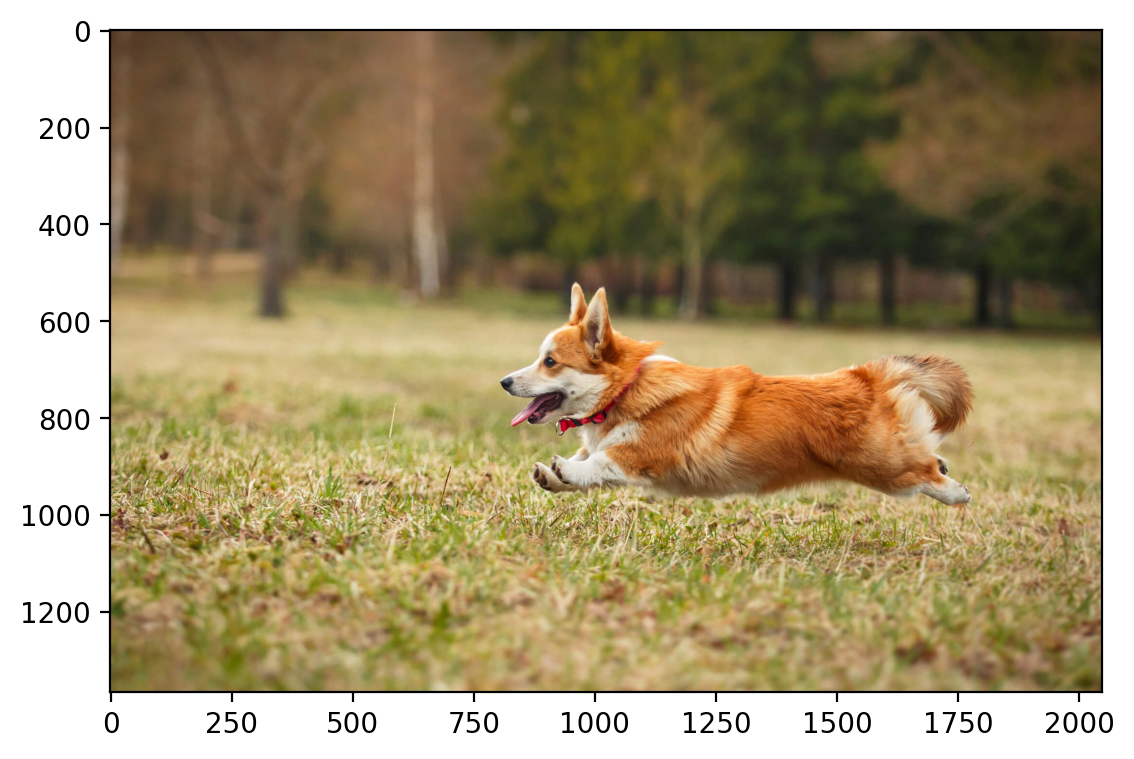

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

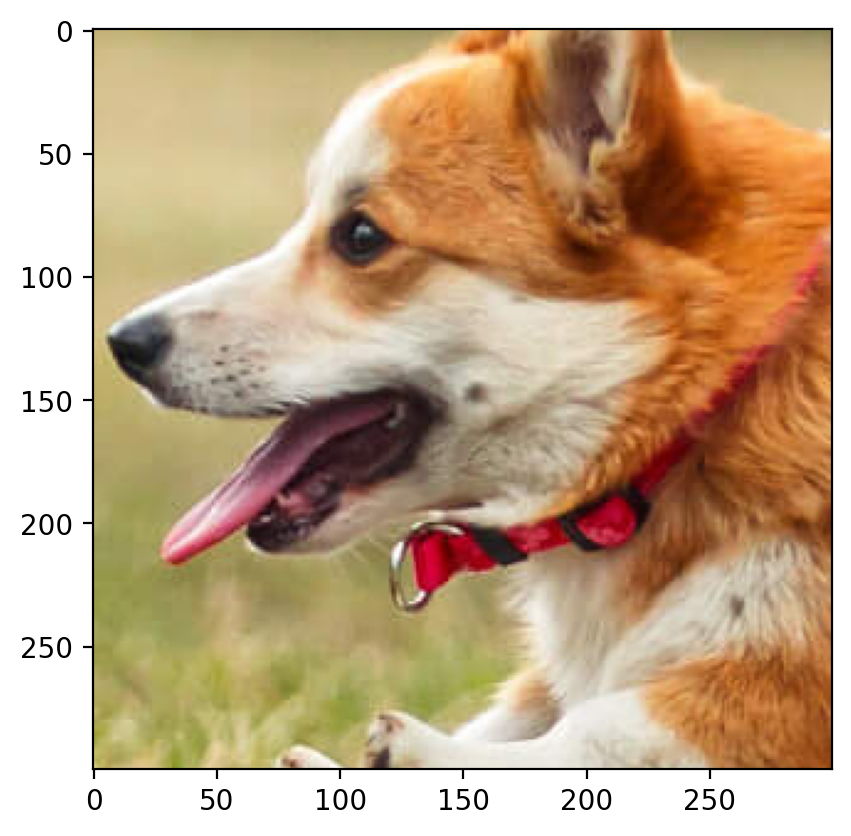

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [10]:
crop = crop.to(device)


In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [12]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [13]:
X.shape

torch.Size([12, 2])

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

In [18]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.297512
Epoch 100 loss: 0.036879
Epoch 200 loss: 0.036823
Epoch 300 loss: 0.036823
Epoch 400 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 600 loss: 0.036823
Epoch 700 loss: 0.036823
Epoch 800 loss: 0.036823
Epoch 900 loss: 0.036823


0.03682255372405052

In [21]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

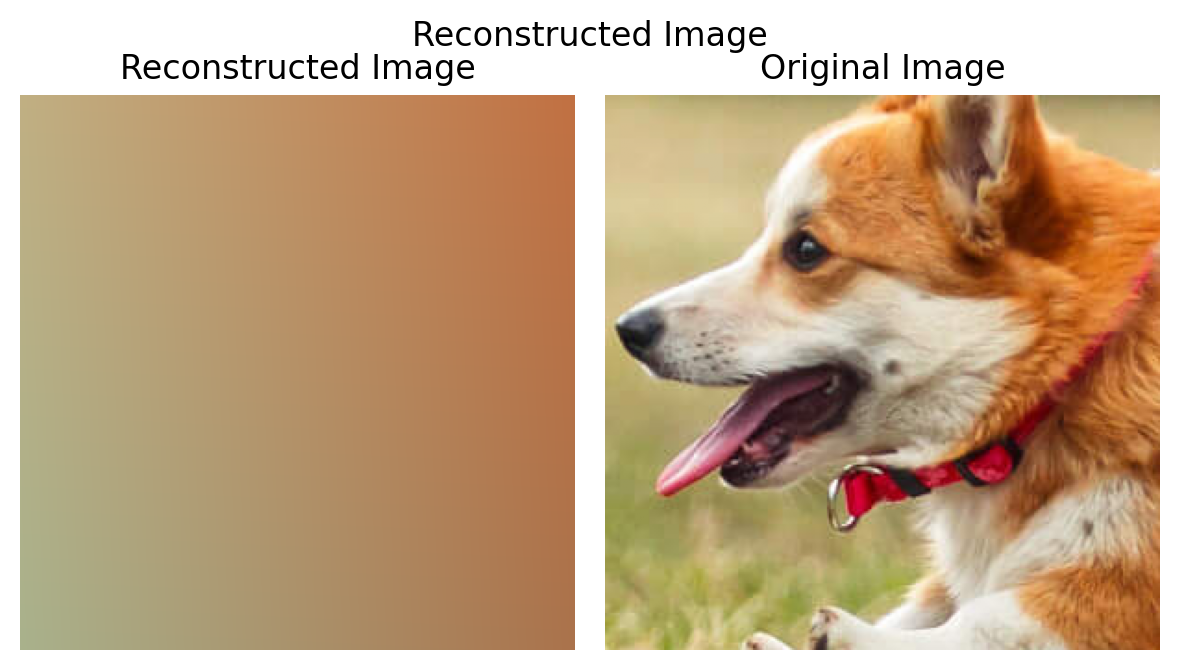

In [22]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

In [23]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [24]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [25]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.369071
Epoch 100 loss: 0.046425
Epoch 200 loss: 0.009751
Epoch 300 loss: 0.004492
Epoch 400 loss: 0.002454
Epoch 500 loss: 0.001409
Epoch 600 loss: 0.000849
Epoch 700 loss: 0.000547
Epoch 800 loss: 0.000383
Epoch 900 loss: 0.000296
Epoch 1000 loss: 0.000251
Epoch 1100 loss: 0.000228
Epoch 1200 loss: 0.000217
Epoch 1300 loss: 0.000211
Epoch 1400 loss: 0.000208
Epoch 1500 loss: 0.000206
Epoch 1600 loss: 0.000204
Epoch 1700 loss: 0.000203
Epoch 1800 loss: 0.000202
Epoch 1900 loss: 0.000202
Epoch 2000 loss: 0.000201
Epoch 2100 loss: 0.000201
Epoch 2200 loss: 0.000200
Epoch 2300 loss: 0.000200
Epoch 2400 loss: 0.000199


0.0001986826246138662

In [32]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
def calculate_rmse(original, reconstructed):
    original = original.cpu().numpy().reshape(-1)
    reconstructed = reconstructed.cpu().numpy().reshape(-1)
    return np.sqrt(mean_squared_error(original, reconstructed))

def calculate_psnr(original, reconstructed):
    original = rearrange(original.cpu(), 'c h w -> h w c').numpy()
    reconstructed = reconstructed.cpu().numpy().reshape(original.shape)
    return psnr(original, reconstructed, data_range=original.max() - original.min())

In [33]:
with torch.no_grad():
    reconstructed = net(X_rff).cpu()
rmse = calculate_rmse(dog_Y, reconstructed)
psnr_value = calculate_psnr(crop, reconstructed)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f}")

Root Mean Squared Error (RMSE): 0.0141
Peak Signal-to-Noise Ratio (PSNR): 37.0185


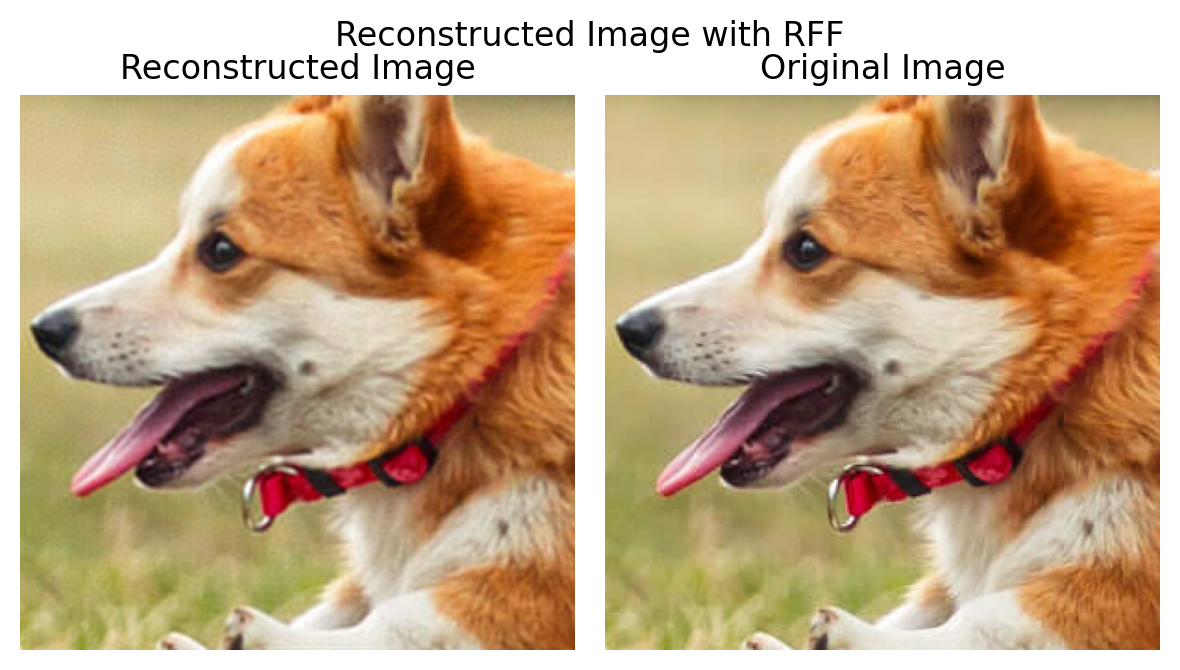

In [34]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF")

### Calculate RMSE and PSNR

In [35]:
def compute_rmse(original, reconstructed):
    original_flat = original.cpu().numpy().flatten()
    reconstructed_flat = reconstructed.cpu().numpy().flatten()
    return np.sqrt(mean_squared_error(original_flat, reconstructed_flat))

def compute_psnr(original, reconstructed):
    original_img = rearrange(original.cpu(), 'c h w -> h w c').numpy()
    reconstructed_img = reconstructed.cpu().numpy().reshape(original_img.shape)
    data_range = original_img.max() - original_img.min()
    return peak_signal_noise_ratio(original_img, reconstructed_img, data_range=data_range)

def evaluate_reconstruction(model, X_rff, Y_original, original_image):
    with torch.no_grad():
        reconstructed = model(X_rff).cpu()
    
    rmse = compute_rmse(Y_original, reconstructed)
    psnr_value = compute_psnr(original_image, reconstructed)
    
    return rmse, psnr_value

In [38]:
rmse, psnr = evaluate_reconstruction(net, X_rff, dog_Y, crop)
print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.4f} dB")

RMSE: 0.0141
PSNR: 37.0185 dB
